<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 0. Abstract

This project implements a parallelised community detection algorithm proposed by [*"S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)"*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. We use Python, Spark and AWS as the environment.

## 1. Introduction

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. Community detection aims at identifying clusters in a network, i.e. regroup vertices into groups of high density connected vertices i.a. to make friends recommendations or target marketing. The Girvan-Newman algorithm is one of the most used for this objective. It uses the concept of edge betweenness, which is a measure of the centrality and influence of an edge in a network, with the shortest-path method.

Given the size of networks and the method used to compute the edge betweenness, parallelization of the computation is unavoidable to realize the task efficiently. Our work is focused on the Shortest-Path Betweeness MapReduce Algorithm (SPB-MRA). Parallelizing computations will be realized at each of the 4 stages of the Map-Reduce algorithm.

Related article:  " Parallel community detection on large graphs with MapReduce and GraphChi" published in 2015 by Seunghyeon Moon, Jae-Gil Lee, Minseo Kang, Minsoo Choy and Jin-woo Lee.

## 2. Model

Community Detection, Modularity Method

## 3. Algorithm

Girvan-Newman Algorithm

<img src="img/algo.png" width="400" align="left">

## 4. Data

- We have 6 network datasets with different number of nodes and edges.
    - Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)

## 5. Environment

Python + Spark on single laptop

Hardware Specification  
CPU: 2.6GHz dual core, Intel Core i5 processor  
Memory: 8GB 1600 MHz DDR3  
OS: macOS Mojave, Version 10.14.2

Although this laptop has 2 physical cores, software recognises 4 logical cores thanks to hyper-threading technology.

## 6. Implementation

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from operator import add
import time

In [2]:
# Check the current directory
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

- We have 6 network datasets with different number of nodes and edges.

In [70]:
# Load a dataset from the six options

#data = np.loadtxt("./Data/test.txt", dtype='uint16')  # 21 nodes,31 edges
data = np.loadtxt("./Data/soc-karate.txt", dtype='uint16')  # 34 nodes,78 edges
#data = np.loadtxt("./Data/Test100.txt", dtype='uint16')  # 103 nodes,239 edges
#data = np.loadtxt("./Data/soc-ANU-residence_without_weights.txt", dtype='uint16')  # 217 nodes, 1839 edges
#data = np.loadtxt("./Data/soc-physicians.txt", dtype='uint16')  # 241 nodes, 923 edges
#data = np.loadtxt("./Data/ca-GrQc_small.txt", dtype='uint16')  # 639 nodes, 617 edges
#data = np.loadtxt("./Data/email-Eu-core.txt", dtype='uint16')  # 986 nodes, 16064 edges

print(type(data))
print(data[:5])  # Display the first 5 rows of the loaded dataset

<class 'numpy.ndarray'>
[[2 1]
 [3 1]
 [4 1]
 [5 1]
 [6 1]]


### 6.1. Spark Configuration
- We first start SparkContext by specifying the number of threads to be used.

In [71]:
# Stop SparkContext if it is already running
try:
    sc.stop()
except NameError:
    pass

from copy import deepcopy  # To make a deep copy of tuple-type data
from pyspark import SparkContext, SparkConf
conf = (SparkConf()
        .setMaster("local[5]")  # Specify the number of threads to be used
        .setAppName("ELTDM")
        .set('spark.executor.memory', '1g')
        .set('spark.driver.memory', '1g'))
sc = SparkContext(conf = conf)
sc

<SparkContext master=local[5] appName=ELTDM>

In [72]:
sc.defaultParallelism

5

In [73]:
sc._conf.getAll()

[('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'ELTDM'),
 ('spark.app.id', 'local-1550418025329'),
 ('spark.driver.port', '56798'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.master', 'local[5]'),
 ('spark.driver.host', '10.25.1.155'),
 ('spark.driver.memory', '1g'),
 ('spark.ui.showConsoleProgress', 'true')]

- Before proceeding, we clean up the dataset (edge list) according to the below three criteria:
    1. Put the node with smaller ID to the left for each edge data (e.g. [3 1] -> [1 3]) (undirectional network)
    2. Filter out self-edge data (e.g. [2 2] -> delete)
    3. Remove duplicate edges

### 6.2. Data Preparation

In [105]:
# Clean up the edge list
rdd = sc.parallelize(data)
d = rdd.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]  # Criterion 1
           ).filter(lambda x: x[0] != x[1]).collect()  # Criterion 2
d = list(set(map(tuple, d)))  # Criterion 3
d = list(map(list, d))
print(type(d))

<class 'list'>


In [140]:
# Save the original node list during the whole process
nodes = list(set([n1 for n1, n2 in d] + [n2 for n1, n2 in d]))
nb_edges_initial = len(d)

print("The data contains")
print(len(nodes), "distinct nodes, and", nb_edges_initial, "distinct edges")

The data contains
34 distinct nodes, and 78 distinct edges


- Let's visualise the initial network of the dataset.

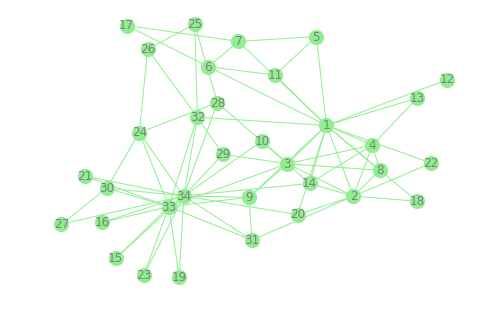

In [141]:
# Visualisation of the graph
def draw_initial_graph(graph):
    
    # Create networkx graph
    G=nx.Graph()
    
    # Add nodes
    for node in nodes:
        G.add_node(node)
        
    # Add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
        
    # Save the positions of the nodes
    pos=nx.get_node_attributes(G,'pos')

    # Configure the graph
    pos = nx.spring_layout(G)
    nx.draw(G, 
            pos, 
            with_labels = True, 
            node_size = 200,  # Set the size of the nodes in the graph
            node_color = 'lightgreen', edge_color = 'lightgreen', font_color = 'gray')
    
    # Save and display the graph
    plt.savefig('./Data/Figures/Pre_Round1.png')
    plt.show()
    
    return pos

np.random.seed(seed=97)
pos = draw_initial_graph(d)  # Save the initial node positions

In [150]:
# Make a list of adjacency lists
# The first element of each adjacency list denotes the node of origin
adj_list = []

for n in nodes:
    
    adj = []

    # If a node in a edge data is the origin (n),
    # add the connected node to its adjacency list
    for i in range(len(d)):
        if d[i][0] == n:
            adj.append(d[i][1])
        if d[i][1] == n:
            adj.append(d[i][0])
    
    adj = list(set(adj)) 
    adj.insert(0, n)  # Label the adjacency list with the node ID of origin
    adj_list.append(adj)

print('Sample: Adjacency list of origin node ID %d is %s' %(adj_list[0][0], adj_list[0]))

Sample: Adjacency list of origin node ID 1 is [1, 32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]


- The format of tuple is : (targetId, sourceId, distance, 'status', weight, [pathInfo], [adjList])

In [154]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []

for n in nodes:
    
    # Create tuples
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    
    # Fill in adjList
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
            
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])

print('Sample: the first tuple is %s' %network[0])

Sample: the first tuple is [1, 1, 0, 'a', 1, [], [32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]]


- Although it is not necessary to convert the input of the initial Stage1 Map into key-value format, we make this conversion in order to be able to put the output of the Stage4 Reduce directly to the Stage1 Map of the next round.

In [161]:
# Key-value conversion
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

### 6.3. Stage 1
- In this stage, the shortest paths between every pair of nodes in the network are calculated.
- This Map-Reduce stage (stage 1) repeats until all tuples have 'i' (inactive) for status.
- The outcome of the iteration of this stage should give a list of tuples which tells the shortest paths between every pair of nodes in the network.


#### Stage 1 - Map 

- In the Map operation, the frontiers are expanded from every node to its adjacent nodes.
- If $status$ is 'a' (active), status is changed to 'i' (inactive), 1 is added to $distance$ and $targetId$ is added to $pathInfo$.
- In addition, new active tuples are generated by assigning each node in $adjList$ to $targetId$, with $distance$ and $pathInfo$ equal to those of the original tuple.
- Thus, this Map is characterised by **Breadth First Search**.

In [95]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result

#### Stage 1 - Reduce 

- In this Reduce operation, among the tuples sharing $sourceId$ and $targetId$, only the tuple that has the minimum value of distance survices.
- If two or more tuples have the same minimum, $weight$ is changed to the number of such tuples to remember the multiplicity of the shortest path.
<br />
<br />
- This Reduce part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [96]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)

In [97]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x

In [98]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v

### 6.4. Stage 2
- In this stage, the edge betweenneses of all eadges in the network are calculated.

#### Stage 2 - Map & Reduce
- In the Map operation, unity is divided to each edge on a shortest path according to the $weight$ of the shortest paths sharing $sourceId$ and $targetId$.
- In the Reduce operation, the contribution of each shortest path is summed up for each stage.

In [99]:
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

### 6.5. Stage 3
- In this stage, $k_iter$ edges are selected according to edge betweenness. By default, $k_iter = 1$.

#### Stage 3 - Map & Reduce

- There is no function to be defined here.
- Refer to $# Stage3$ of <a href='#Rounds Stage1-4'>6.8. Rounds Stage1-4</a>.

### 6.6. Stage4
- In this stage, the edges selected by Stage 3 are removed from the network. Then, a new set of tuples are generated to reflect the removed edges since edge betweenness needs to be recalculated in the next round.

#### Stage4 - Map

In [100]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1  # Increase counter if its key is affected by the removal of the edge(s)
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

#### Stage4 - Reduce

In [101]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x+y
def revision(x):  # To flatten the pressed tuples (ones with status i)
    tup = []
    if len(x[1]) > 6:
        for i in range(int(len(x[1])/6)):
            tup.append((x[0],x[1][i*6:i*6+6]))
        return tup
    else:
        return [x]

In [102]:
def from_tuples_to_edgelist(x):
    res = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            res.append([x[i][0], x[i][1][5][j]])
    res = set(map(tuple, res))  # Remove duplicate edges
    res = list(res)
    result = list(map(list, res))
    return result

In [107]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

nodes = set([n1 for n1, n2 in data] + [n2 for n1, n2 in data])
r = 1
def draw_graph(graph, r):
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    nx.draw(G, pos = pos, with_labels = True, node_size=nsize, node_color="lightgreen", edge_color='lightgreen', font_color='gray')
    # show graph
    t = float(time.time())
    plt.savefig('./Data/Figures/Post_Round_%d.png' %r)
    plt.show()

### 6.7. Modularity Q
- In order to measure the goodness of a community we find, We employ Modularity Q proposed by [*Newman and Girvan, Finding and evaluating community structure in networks, Physical Review (2004)*.](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf)
- Modularity Q measures the strengh of the community structure of the network.

[To be summarised]
- Consider a particular division of a network into k communi- ties. Let us define a k􏰊k symmetric matrix e whose element eij is the fraction of all edges in the network that link verti- ces in community i to vertices in community j 􏰃50􏰁. 􏰅Here we consider all edges in the original network—even after edges have been removed by the community structure algorithm, our modularity measure is calculated using the full network.􏰀
The trace of this matrix Tr e􏰋􏰂ieii gives the fraction of edges in the network that connect vertices in the same com- munity, and clearly a good division into communities should have a high value of this trace. The trace on its own, how- ever, is not a good indicator of the quality of the division since, for example, placing all vertices in a single community would give the maximal value of Tr e􏰋1 while giving no information about community structure at all.
So we further define the row 􏰅or column􏰀 sums ai 􏰋 􏰂 j e i j , which represent the fraction of edges that connect to vertices in community i. In a network in which edges fall between vertices without regard for the communities they belong to, we would have eij􏰋aiaj . Thus we can define a modularity measure by:  
$Q=\sum_{i}(e_{ii}-a_i^2) = \mathrm{Tr}\ {\bf e} - \|{\bf e}^2\|$
- where 􏰒x􏰒 indicates the sum of the elements of the matrix x. This quantity measures the fraction of the edges in the net- work that connect vertices of the same type 􏰅i.e., within- community edges􏰀 minus the expected value of the same quantity in a network with the same community divisions but random connections between the vertices. If the number of within-community edges is no better than random, we will get Q􏰋0. Values approaching Q􏰋1, which is the maximum, indicate networks with strong community structure 􏰃51􏰁. In practice, values for such networks typically fall in the range from about 0.3 to 0.7. Higher values are rare.

In [108]:
def Q_modularity(elist, nodes):

# Read and clean up edges
    c = sc.parallelize(elist)
    c = c.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]).filter(lambda x: x[0] != x[1]).collect()  # remove edge between a sigle node and prepare to remove duplicate edges
    c = set(map(tuple, c))  # Remove duplicate edges
    c = list(c)
    c = list(map(list, c))

# Make a graph for NetworkX library
    H=nx.Graph()
    # add nodes
    for node in nodes:
        H.add_node(node)
    # add edges
    for edge in c:
        H.add_edge(edge[0], edge[1])

# Make a community dictionary from the edge list {nodeId: communityId}
    com_dic = {}
    com_id = 0

    for n in nodes:
        try:
            com_dic[n]
        except KeyError:
            com_id += 1
            com_dic[n] = com_id
            for m in nodes:
                if (n != m) and (nx.has_path(H, m, n)):  # has_path(G, source, target): return True if there is a path
                    try:
                        com_dic[m]
                    except KeyError:
                        com_dic[m] = com_id

    com_ids = list(set(com_dic.values()))
    com_ids

# Create a matrix `e` to calculate Q
    e = np.matrix([[0.]*len(com_ids)]*len(com_ids))

# Fill in `e` 
    for i in range(len(com_ids)):
        for j in range(len(com_ids)):
            keys_i = [k for k, v in com_dic.items() if v == i+1]
            keys_j = [k for k, v in com_dic.items() if v == j+1]
            if i == j:  # Fraction of edges that are within the same community
                nb_within = 0
                for edge in c:
                    if set(edge) <= set(keys_i):
                        nb_within += 1
                e[i, i] = nb_within/nb_edges_initial
            elif i < j:  # Fraction of edges that cross between community i and community j
                nb_cross = 0
                for edge in d:
                    if (({edge[0]} <= set(keys_i)) and ({edge[1]} <= set(keys_j))) or (({edge[0]} <= set(keys_j)) and ({edge[1]} <= set(keys_i))):
                        nb_cross += 1
                e[i, j] = nb_cross/nb_edges_initial
                e[j, i] = nb_cross/nb_edges_initial

    a = np.ndarray.sum(e, axis=1)  
    a = np.squeeze(np.asarray(a))

# Calculate Q 
    Q = float(e.trace()) - np.dot(a, a)

    return Q, com_dic

<a id='Rounds Stage1-4'></a>

### 6.8. Rounds Stage1-4
- Finally we run the code using the functions defined above.

Data contains 34 nodes, and 78 edges 

ROUND 1 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 156 / 190 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 1056 / 1246 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling i

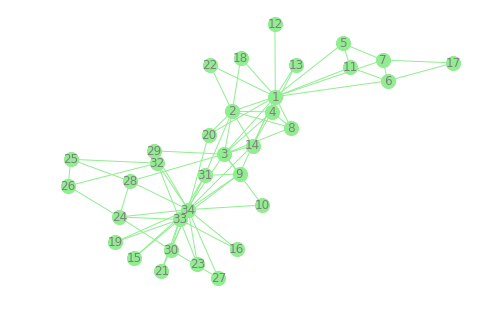

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.012656147271531859
Round 1 took 11.3 seconds ( 0.2 mins)

 

ROUND 2 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 154 / 188 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

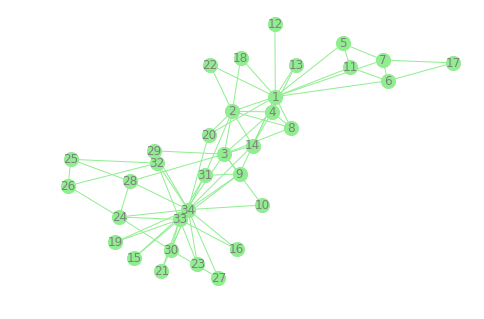

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.024983563445101886
Round 2 took 13.0 seconds ( 0.2 mins)

 

ROUND 3 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 152 / 186 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

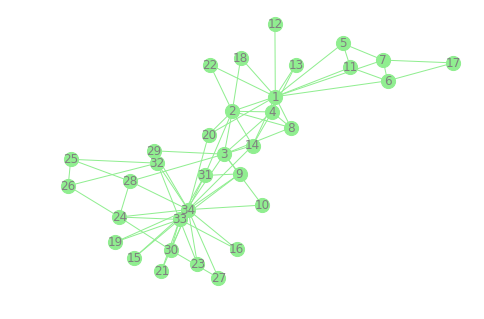

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.03698224852071008
Round 3 took 13.3 seconds ( 0.2 mins)

 

ROUND 4 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 150 / 184 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

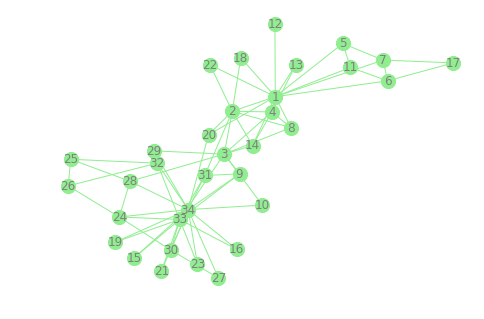

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.048652202498356334
Round 4 took 13.9 seconds ( 0.2 mins)

 

ROUND 5 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 148 / 182 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

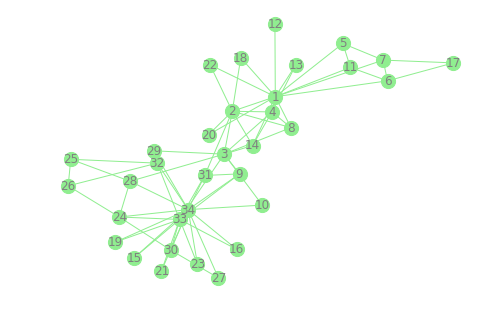

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.059993425378040754
Round 5 took 13.5 seconds ( 0.2 mins)

 

ROUND 6 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 146 / 180 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

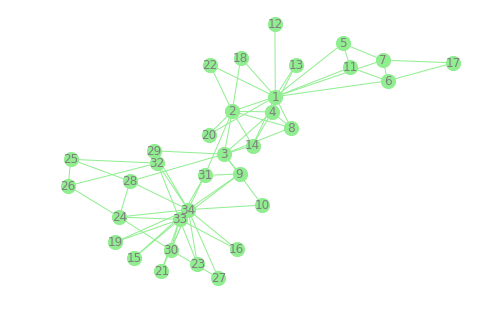

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.07100591715976323
Round 6 took 21.2 seconds ( 0.4 mins)

 

ROUND 7 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 144 / 178 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

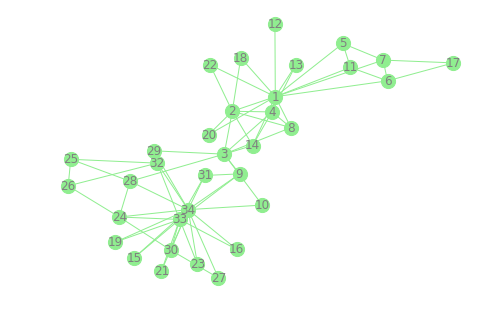

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.08168967784352399
Round 7 took 25.0 seconds ( 0.4 mins)

 

ROUND 8 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 142 / 176 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

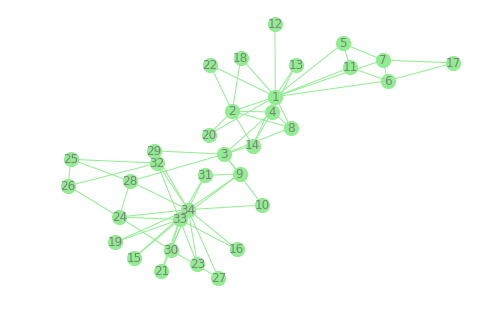

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.0920447074293228
Round 8 took 29.9 seconds ( 0.5 mins)

 

ROUND 9 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 140 / 174 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

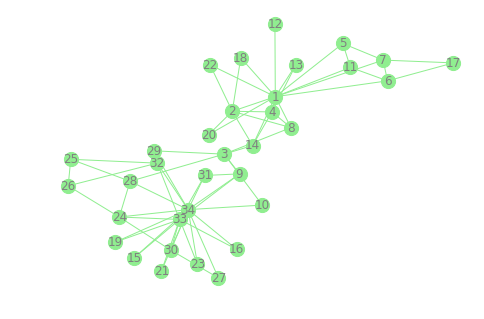

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.10207100591715978
Round 9 took 35.8 seconds ( 0.6 mins)

 

ROUND 10 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 138 / 172 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

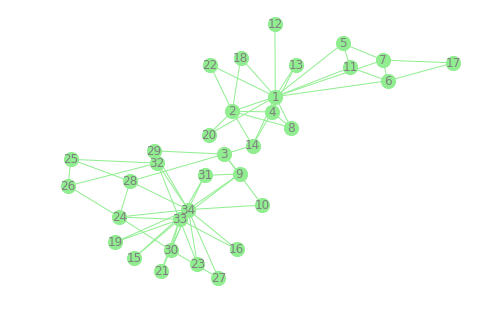

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.11176857330703482
Round 10 took 33.3 seconds ( 0.6 mins)

 

ROUND 11 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 136 / 170 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0

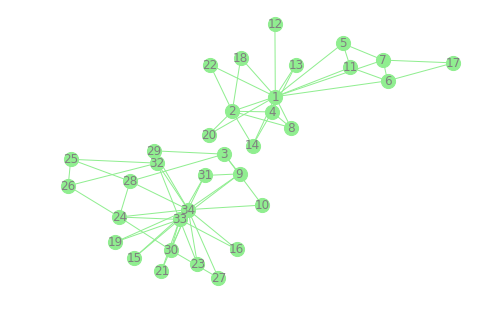

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.22698882314266933
Round 11 took 31.7 seconds ( 0.5 mins)

 

ROUND 12 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 134 / 168 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0

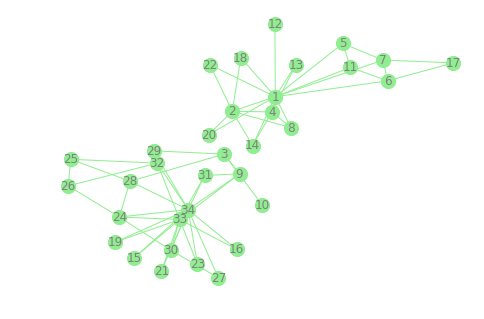

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.23011176857330695
Round 12 took 22.4 seconds ( 0.4 mins)

 

ROUND 13 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 76 / 382 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

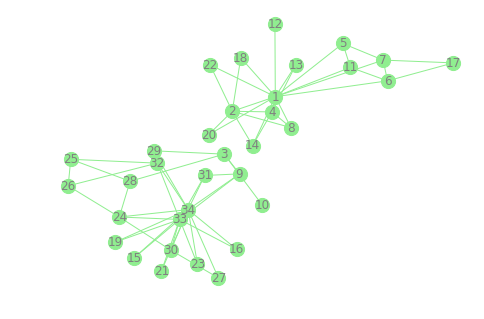

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.23290598290598286
Round 13 took 21.9 seconds ( 0.4 mins)

 

ROUND 14 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 74 / 380 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

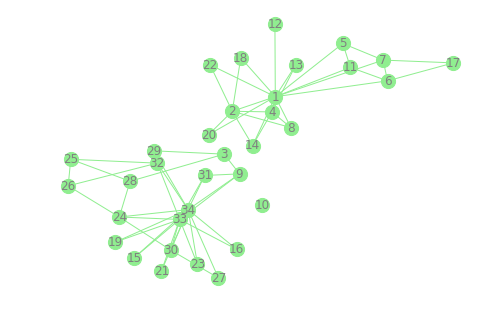

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20381328073635752
Round 14 took 24.1 seconds ( 0.4 mins)

 

ROUND 15 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 72 / 378 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

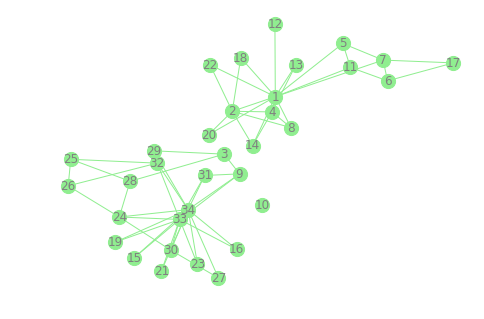

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20332018408941477
Round 15 took 25.2 seconds ( 0.4 mins)

 

ROUND 16 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 54 / 616 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

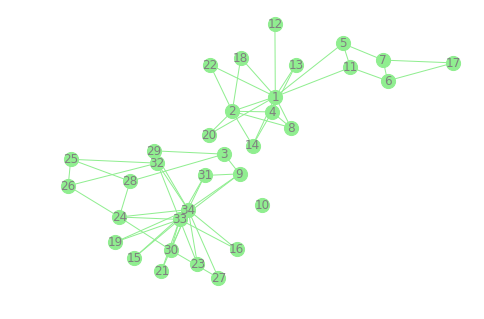

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.2024983563445102
Round 16 took 23.5 seconds ( 0.4 mins)

 

ROUND 17 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 52 / 614 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

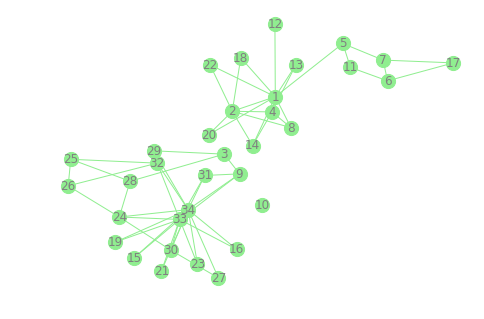

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20134779750164367
Round 17 took 22.3 seconds ( 0.4 mins)

 

ROUND 18 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 50 / 612 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

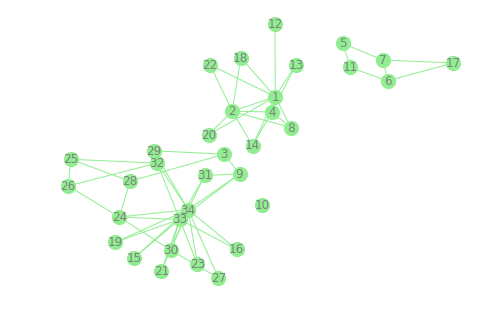

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.20512820512820495
Round 18 took 22.4 seconds ( 0.4 mins)

 

ROUND 19 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 48 / 610 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

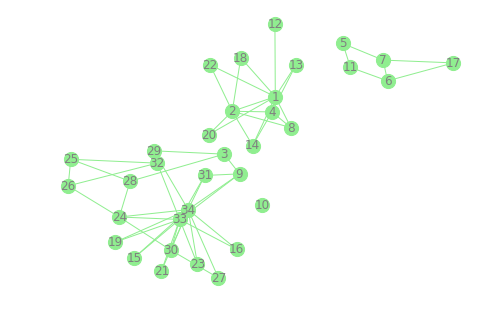

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.20792241946088097
Round 19 took 19.5 seconds ( 0.3 mins)

 

ROUND 20 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 70 / 252 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

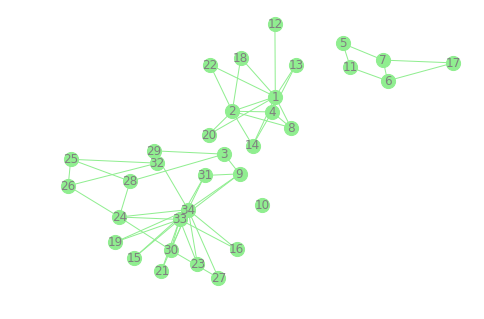

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21038790269559493
Round 20 took 22.9 seconds ( 0.4 mins)

 

ROUND 21 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 68 / 250 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

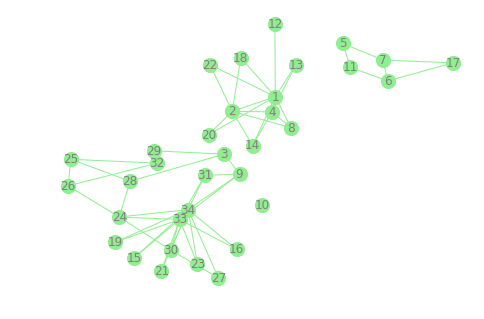

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21252465483234706
Round 21 took 22.1 seconds ( 0.4 mins)

 

ROUND 22 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 66 / 248 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

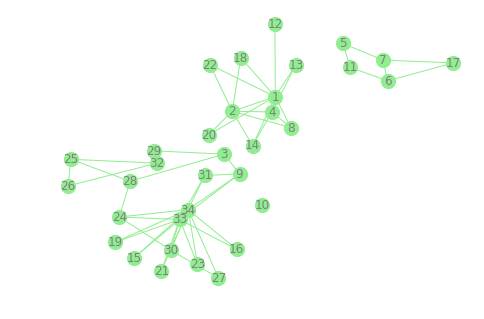

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21433267587113725
Round 22 took 25.1 seconds ( 0.4 mins)

 

ROUND 23 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 64 / 246 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

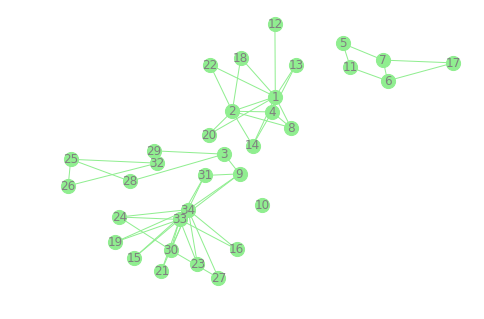

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21581196581196588
Round 23 took 25.3 seconds ( 0.4 mins)

 

ROUND 24 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 62 / 244 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

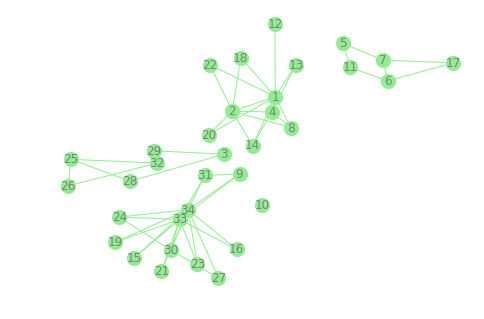

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 27: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5}
(There are 5 communities now)
Q Modularity is: 0.21433267587113736
Round 24 took 27.9 seconds ( 0.5 mins)

 

ROUND 25 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 60 / 242 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

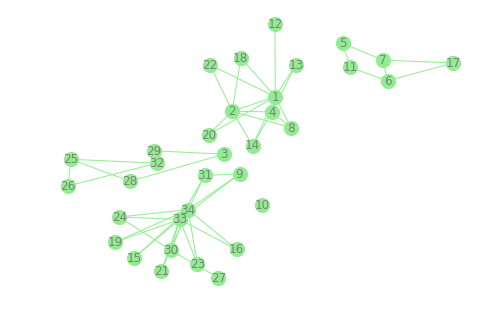

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 27: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5}
(There are 5 communities now)
Q Modularity is: 0.2131821170282709
Round 25 took 23.3 seconds ( 0.4 mins)

 

ROUND 26 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 44 / 258 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

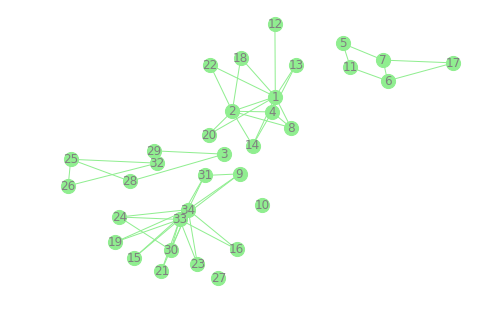

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 27: 6}
(There are 6 communities now)
Q Modularity is: 0.1880341880341881
Round 26 took 23.4 seconds ( 0.4 mins)

 

ROUND 27 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 42 / 256 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

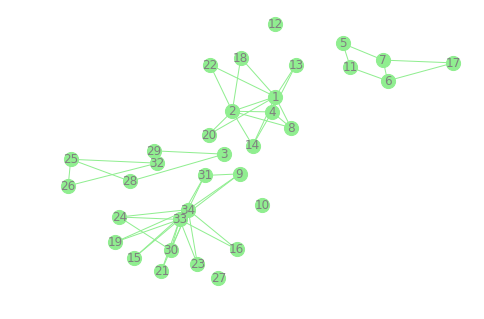

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 27: 7}
(There are 7 communities now)
Q Modularity is: 0.17504930966469429
Round 27 took 20.6 seconds ( 0.3 mins)

 

ROUND 28 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 34 / 302 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

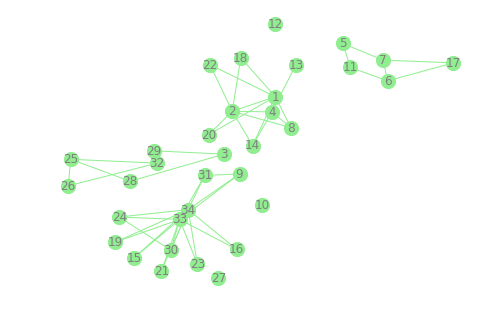

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 27: 7}
(There are 7 communities now)
Q Modularity is: 0.1725838264299802
Round 28 took 19.4 seconds ( 0.3 mins)

 

ROUND 29 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 32 / 300 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

KeyboardInterrupt: 

In [109]:
# Iteration of Stage1-4
import matplotlib.pyplot as plt
import time

print("Data contains", len(nodes), "nodes, and", nb_edges_initial, "edges \n")

# Parameter initialisation
k_iter = 1  # Number of edges to be removed at each round. The default value is 1.
r=1
removed_edges=[]
t_initial = time.time()
Q = 0
elist_hist = []
Q_hist = []
community_hist = []
t_hist = []

while Q >= 0:
    print("ROUND", r, "STARTED! \n")
    
# Stage1
    t_start = time.time() 
    # Iteration until status becomes 'i' for all tuples
    act_counter = 1
    ite = 1
    while act_counter > 0:
        print("Iteration", ite, "started...")
        rdd = sc.parallelize(output)#.repartition(sc.defaultParallelism * 3)

    # <stage1 map>
        print(" Now doing Map..")
        pos_map1 = rdd.flatMap(stage1_map)
    # <stage1 reduce>
        print(" Now doing Reduce..")
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        print(" Now collecting Reduce result..")
        t1 = time.time()
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        print("  Collecting Reduce result took", round(t2-t1, 1), "seconds (", round((t2-t1)/60, 1), "mins ).")
        print(" Now flattening Reduce result..")
        t3 = time.time()
        
        # 'for' loop to flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        t4 = time.time()
        print("  Flattening took", round(t4-t3, 1), "seconds (", round((t4-t3)/60, 1), "mins ).")
        print(" Now finalising Reduce result by filling in adjList..")
        # Fill in adjList before going to next iteration
        t5 = time.time()    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        t6 = time.time()
        print("  Filling in adjList took", round(t6-t5, 1), "seconds (", round((t6-t5)/60, 1), "mins ).")
        print(" Now iteration",ite ,"finished!")
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("Iteration", ite, "finished. There are", act_counter, "/", len(output), "active tuples left. \n")
        ite += 1
    stage1_output = output.copy()
    print("All the Stage1 iterations have finished. Stage1 was iterated for", ite-1, "times.")
    #print("Stage1 result is:")  # DELETE AFTER DEBUGGING
    #for i in range(len(stage1_output)):  # DELETE AFTER DEBUGGING
    #    print(stage1_output[i])  # DELETE AFTER DEBUGGING
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("Stage1 execution time was", round(elapsed_time, 1), "seconds (", round(elapsed_time_min, 1), "mins ).")

# Stage2
    pre_map2 = sc.parallelize(stage1_output)#.repartition(sc.defaultParallelism * 3)
    # Apply Map after filtering out tuples which has single node info and duplicated tuples (as we consider undirected graph network)
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    # Stage2 Reduce
    pos_red2_directed = pos_map2.reduceByKey(add)
    # Ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)

# Stage3
    # Stage3 Map & Reduce
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top10 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(10)
    print("Edge betweenness Score Top 10 is:", top10)   
    print("Round", r, "removes", distributed_cache)
    removed_edges.append(distributed_cache)
    
# Stage4
    pos_map4 = pre_map2.flatMap(stage4_map)
    pos_red4 = pos_map4.reduceByKey(stage4_reduce).flatMap(revision)
    output = pos_red4.collect()
    elist = from_tuples_to_edgelist(output)
    print("After the edge removal, the graph is:")
    np.random.seed(seed=1234)
    draw_graph(elist, r)

# Update adj_list 
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    adj_list = set(map(tuple, adj_list))  # Remove duplicates
    adj_list = list(adj_list)
    adj_list = list(map(list, adj_list))
# Calculate Q
    Q_fun_result = Q_modularity(elist, nodes)
    Q = Q_fun_result[0]
    community = Q_fun_result[1]
    print("Community Labelling is:", community)
    print('(There are', len(set(community.values())), 'communities now)')
    print("Q Modularity is:", Q)

# Store the result histories
    Q_hist.append(Q)
    elist_hist.append(elist)
    community_hist.append(community)
    t_hist.append(time.time()-t_initial)
    t_r_end = time.time() 
    r_time = t_r_end - t_start
    print('Round', r, 'took', round(r_time, 1), 'seconds (', round(r_time/60, 1), 'mins)')
    r += 1
    print("\n \n")
t_terminal = time.time()
total_time = t_terminal - t_initial

# Give the conclusion
print('Since the Q modularity reached less than 0, we ended the calculations.')
print('All the ', r-1, 'rounds finished')
print('\nTotal execution time was', round(total_time, 1), 'seconds (', round(total_time/60, 1), 'mins)\n')
print('Removed edges were', removed_edges)
print('Please check the saved figures under "./Data/Figures"')
x_axis = [x+1 for x in range(r-1)]
plt.plot(x_axis, Q_hist)
plt.title("Evolution of Q")
plt.xlabel("Round")
plt.ylabel("Q Modularity")
plt.savefig('./Data/Figures/Q_Modularity_evolution.png')
plt.show()

Q_best = Q_hist[np.argmax(Q_hist)]
r_best = np.argmax(Q_hist) + 1
elist_best = elist_hist[np.argmax(Q_hist)]
community_best = community_hist[np.argmax(Q_hist)]
t_best = t_hist[np.argmax(Q_hist)]

print('Q list is:', Q_hist)
print('\n Maximum Q was achieved at round', r_best, 'and the value was', Q_best)
print(' The best community structure is:', community_best)
print('  and there are', len(set(community_best.values())), 'communities.')
print(' The graph at the best was:')
draw_graph(elist_best, r_best)
print(' It took', round(t_best, 1), 'seconds (', round((t_best)/60, 1), 'mins) until the network reaches the best community structure.')


## 7. Result and discussion

1) Try with different datasets with different size  
2) Scale out (increase the number of computing instances)  
3) In which case we better use Spark?

## 9. References

1) S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)  
2) M.E. Newman, M. Girvan, Finding and evaluating community structure in networks, Phys. Rev. E 69 (2) (2004) 026113  